In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Data Class**

In [0]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
import datetime, os

from tqdm import tqdm
import tarfile
import pickle
import numpy as np

import skimage
import skimage.io
import skimage.transform
from skimage.util import random_noise
import math
import random
import matplotlib.pyplot as plt

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

class Data:
  def __init__(self, **kwargs):
    self.dataset_name = kwargs.get("dataset_name", 'cifar-100-python.tar.gz')
    self.dataset_alias = kwargs.get("dataset_alias", 'CIFAR100')
    self.dataset_link = kwargs.get("dataset_link", 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz')
    self.labels = kwargs.get("labels", [
                                            'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
                                            'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
                                            'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
                                            'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
                                            'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
                                            'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
                                            'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
                                            'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
                                            'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                                            'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
                                            'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
                                            'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
                                            'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
                                            'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
                                            'worm'
                                        ])
    self.n_batches = kwargs.get("n_batches", 1)
    self.test_container_name = kwargs.get("test_container_name", 'test')
    self.labels_col_name = kwargs.get("labels_col_name", 'fine_labels')
    self.batch_size = kwargs.get("batch_size", 45000)
    self.dataset_folder_path = kwargs.get("dataset_folder_path", 'cifar-100-python')
    self.batched = kwargs.get("batched", False)
  
  def download(self):
    if not isfile(self.dataset_name):
      with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc=(self.dataset_alias + ' Dataset')) as pbar:
          urlretrieve(
            self.dataset_link,
            self.dataset_name,
            pbar.hook)
    else:
      print(self.dataset_name + ' already exists')

    if not isdir(self.dataset_folder_path):
      with tarfile.open(self.dataset_name) as tar:
        tar.extractall()
        tar.close()
    else:
      print(self.dataset_alias + ' dataset already exists')

  def label_to_name(self):
    return self.labels

  def load_batch(self, batch_id):
    with open(self.dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
      batch = pickle.load(file, encoding='latin1')
    
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

  def load_all(self):
    with open(self.dataset_folder_path + '/train', mode='rb') as file:
      batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['fine_labels']

    return features, labels

  def one_hot_encode(self, x):
    encoded = np.zeros((len(x), len(self.labels)))

    for idx, val in enumerate(x):
      encoded[idx][val] = 1

    return encoded

  def _preprocess_and_save(self, features, labels, filename):
    labels = self.one_hot_encode(labels)
    pickle.dump((features, labels), open(filename, 'wb'))

  def preprocess_and_save_data(self):
    valid_features = []
    valid_labels = []

    _features = []
    _labels = []
    for batch_i in range(1, self.n_batches + 1):
      if not self.batched:
        _features, _labels = self.load_all()
      else:
        if batch_i > 5:
          break
        features, labels = self.load_batch(batch_i)
        _features.extend(features)
        _labels.extend(labels)

    self._preprocess_and_save(
                      _features, _labels,
                      self.dataset_alias + '_preprocess_batch_' + str(1) + '.p')

    with open(self.dataset_folder_path + '/' + self.test_container_name, mode='rb') as file:
      batch = pickle.load(file, encoding='latin1')

    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch[self.labels_col_name]

    self._preprocess_and_save(
                      np.array(test_features), np.array(test_labels),
                      self.dataset_alias + '_preprocess_validation.p')

  def batch_features_labels(self, features, labels):
    for start in range(0, len(features), self.batch_size):
      end = min(start + self.batch_size, len(features))
      yield features[start:end], labels[start:end]

  def load_preprocess_training_batch(self, batch_id = 1):
    filename = self.dataset_alias + '_preprocess_batch_1.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    features = features[(batch_id-1)*self.batch_size:batch_id*self.batch_size]
    labels = labels[(batch_id-1)*self.batch_size:batch_id*self.batch_size]
    return features, labels


# **AlexNet**

In [0]:
import argparse
import sys
import pickle
import numpy as np
import random

import tensorflow as tf
from tensorflow.contrib.layers import conv2d
from tensorflow.contrib.layers import max_pool2d
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import fully_connected

losses = []

class AlexNet:
    def __init__(self, dataset, learning_rate):

        self.dataset = dataset
        self.learning_rate = tf.placeholder(tf.float32, name="lr")
        self.a1 = tf.Variable(1.)
        self.a2 = tf.Variable(1.)
        self.learning_r = learning_rate

        self.input = tf.placeholder(tf.float32, [None, 32, 32, 3], name='input')
        self.tr_input = tf.image.resize(self.input, [224, 224])
        self.label = tf.placeholder(tf.int32, [None, len(self.dataset.labels)], name='label')
        self.prob = tf.placeholder_with_default(1.0, shape=(), name="prob")

        self.logits = self.load_model()
        self.model = tf.identity(self.logits, name='logits')

        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.label), name='cost')
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate, name='adam').minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.model, 1), tf.argmax(self.label, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32), name='accuracy')

        #augmentation layers
        self.img = tf.placeholder(dtype = tf.float32, shape = [None, 32, 32, 3], name="augmentor")
        self.rnd = random.uniform(0, 0.2)
        self.flip = tf.image.random_flip_left_right(self.img)
        self.flip1 = tf.image.random_flip_up_down(self.img)
        self.rotate = tf.contrib.image.rotate(self.img, self.a1)
        self.rnd1 = random.uniform(-2, 2)
        self.rnd2 = random.uniform(-2, 2)
        self.translate = tf.contrib.image.translate(self.img, [self.a1, self.a2])
        self.bright = tf.image.random_brightness(self.img, 0.2)
        self.contrast = tf.image.random_contrast(self.img, 0.8, 0.9)
        self.hue = tf.image.random_hue(self.img, 0.1)
        self.saturation = tf.image.random_saturation(self.img, 1, 2)

    def update_learning_rate(self, learning_rate):
      self.learning_r = learning_rate
    def load_model(self):
        # 1st
        conv1 = conv2d(self.tr_input, num_outputs=96,
                    kernel_size=[11,11], stride=4, padding="VALID",
                    activation_fn=tf.nn.relu)
        lrn1 = tf.nn.local_response_normalization(conv1, bias=2, alpha=0.0001,beta=0.75)
        pool1 = max_pool2d(lrn1, kernel_size=[3,3], stride=2)

        # 2nd
        conv2 = conv2d(pool1, num_outputs=256,
                    kernel_size=[5,5], stride=1, padding="VALID",
                    biases_initializer=tf.ones_initializer(),
                    activation_fn=tf.nn.relu)
        lrn2 = tf.nn.local_response_normalization(conv2, bias=2, alpha=0.0001, beta=0.75)
        pool2 = max_pool2d(lrn2, kernel_size=[3,3], stride=2)

        #3rd
        conv3 = conv2d(pool2, num_outputs=384,
                    kernel_size=[3,3], stride=1, padding="VALID",
                    activation_fn=tf.nn.relu)

        #4th
        conv4 = conv2d(conv3, num_outputs=384,
                    kernel_size=[3,3], stride=1, padding="VALID",
                    biases_initializer=tf.ones_initializer(),
                    activation_fn=tf.nn.relu)

        #5th
        conv5 = conv2d(conv4, num_outputs=256,
                    kernel_size=[3,3], stride=1, padding="VALID",
                    biases_initializer=tf.ones_initializer(),
                    activation_fn=tf.nn.relu)
        pool5 = max_pool2d(conv5, kernel_size=[3,3], stride=2)

        #6th
        flat = flatten(pool5)
        fcl1 = fully_connected(flat, num_outputs=4096,
                                biases_initializer=tf.ones_initializer(), activation_fn=tf.nn.relu)
        dr1 = tf.nn.dropout(fcl1, self.prob)

        #7th
        fcl2 = fully_connected(dr1, num_outputs=4096,
                                biases_initializer=tf.ones_initializer(), activation_fn=tf.nn.relu)
        dr2 = tf.nn.dropout(fcl2, self.prob)

        #output
        out = fully_connected(dr2, num_outputs=len(self.dataset.labels), activation_fn=None)
        return out

    def train_from_ckpt(self, epochs, valid_set, save_model_path, start_epoch):
        tmpValidFeatures, valid_labels = valid_set

        loaded_graph = tf.Graph()

        with tf.Session(graph=loaded_graph) as sess:
            loader = tf.train.import_meta_graph(save_model_path+"_"+str(start_epoch) + '.meta')
            loader.restore(sess, save_model_path+"_"+str(start_epoch))

            self.learning_rate = loaded_graph.get_tensor_by_name('lr:0')
            self.a1 = loaded_graph.get_tensor_by_name('Variable:0')
            self.a2 = loaded_graph.get_tensor_by_name('Variable:0')
            self.prob = loaded_graph.get_tensor_by_name('prob:0')
            loaded_x = loaded_graph.get_tensor_by_name('input:0')
            loaded_y = loaded_graph.get_tensor_by_name('label:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_cost = loaded_graph.get_tensor_by_name('cost:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            self.img = loaded_graph.get_tensor_by_name("augmentor:0")
            self.translate = loaded_graph.get_tensor_by_name("translate/transform/ImageProjectiveTransformV2:0")
            self.hue = loaded_graph.get_tensor_by_name("adjust_hue/Identity:0")
            self.saturation = loaded_graph.get_tensor_by_name("adjust_saturation/Identity:0")
            self.bright = loaded_graph.get_tensor_by_name("adjust_brightness/Identity:0")
            self.rotate = loaded_graph.get_tensor_by_name("rotate/transform/ImageProjectiveTransformV2:0")
            self.contrast = loaded_graph.get_tensor_by_name("adjust_contrast/Identity:0")
            self.flip = loaded_graph.get_tensor_by_name("random_flip_left_right/add:0")
            self.flip1 = loaded_graph.get_tensor_by_name("random_flip_up_down/add:0")

            loaded_optimizer = loaded_graph.get_operation_by_name('adam')

            print('starting training ... ')
            for epoch in range(epochs):

                # learning rate scheduling
                if epoch+start_epoch-0 < 20:
                  self.learning_r = 0.0001
                elif epoch+start_epoch-0 < 40:
                  self.learning_r = 0.00009
                elif epoch+start_epoch-0 < 60:
                  self.learning_r = 0.00006
                elif epoch+start_epoch-0 < 80:
                  self.learning_r = 0.00003
                elif epoch+start_epoch-0 < 100:
                  self.learning_r = 0.00001
                elif epoch+start_epoch-0 < 120:
                  self.learning_r = 0.000009
                elif epoch+start_epoch-0 < 140:
                  self.learning_r = 0.000006
                elif epoch+start_epoch-0 < 160:
                  self.learning_r = 0.000003
                elif epoch+start_epoch-0 < 180:
                  self.learning_r = 0.000001

                tac = 0
                for batch_i in range(1, self.dataset.n_batches + 1):
                    va, ta = self._train(sess,
                                        loaded_x, loaded_y, loaded_optimizer, loaded_acc,
                                        epoch, batch_i, valid_set, loaded_cost)
                    tac += ta


                sys.stdout.write("\r"+"Epoch: "+str(start_epoch+epoch+1)+" Validation accuracy: "+str(va)+" Training accuracy: "+str(tac/self.dataset.n_batches)+"\n")
                sys.stdout.flush()

                if epoch%25 == 0:
                  saver = tf.train.Saver()
                  save_path = saver.save(sess, save_model_path+"_"+str(start_epoch+epoch+1))

    def _train(self, sess,
                        input, label, optimizer, accuracy,
                        epoch, batch_i, valid_set, cost):
        tmpValidFeatures, valid_labels = valid_set
        tot_loss = 0
        batch_features, batch_labels = self.dataset.load_preprocess_training_batch(batch_i)


        # Augmentation
        _rnd = random.random()
        if _rnd < 1/9:
          batch_features = sess.run(self.flip, feed_dict = {self.img : batch_features})
        elif _rnd < 2/9:
          batch_features = sess.run(self.flip1, feed_dict = {self.img : batch_features})
        elif _rnd < 3/9:
          rnd = math.radians(random.uniform(-180, 180))
          batch_features = sess.run(self.rotate, feed_dict = {self.img : batch_features, self.a1: rnd})
        elif _rnd < 4/9:
          rnd1 = random.uniform(-6, 6)
          rnd2 = random.uniform(-6, 6)
          batch_features = sess.run(self.translate, feed_dict = {self.img : batch_features, self.a1: rnd1, self.a2: rnd2})
        elif _rnd < 5/9:
          batch_features = sess.run(self.bright, feed_dict = {self.img : batch_features})
        elif _rnd < 6/9:
          batch_features = sess.run(self.contrast, feed_dict = {self.img : batch_features})
        elif _rnd < 7/9:
          batch_features = sess.run(self.hue, feed_dict = {self.img : batch_features})
        elif _rnd < 8/9:
          batch_features = sess.run(self.saturation, feed_dict = {self.img : batch_features})
        elif _rnd < 9/9:
          batch_features = batch_features

        _rnd = random.random()
        if _rnd < 1/9:
          batch_features = sess.run(self.flip, feed_dict = {self.img : batch_features})
        elif _rnd < 2/9:
          batch_features = sess.run(self.flip1, feed_dict = {self.img : batch_features})
        elif _rnd < 3/9:
          rnd = math.radians(random.uniform(-180, 180))
          batch_features = sess.run(self.rotate, feed_dict = {self.img : batch_features, self.a1: rnd})
        elif _rnd < 4/9:
          rnd1 = random.uniform(-6, 6)
          rnd2 = random.uniform(-6, 6)
          batch_features = sess.run(self.translate, feed_dict = {self.img : batch_features, self.a1: rnd1, self.a2: rnd2})
        elif _rnd < 5/9:
          batch_features = sess.run(self.bright, feed_dict = {self.img : batch_features})
        elif _rnd < 6/9:
          batch_features = sess.run(self.contrast, feed_dict = {self.img : batch_features})
        elif _rnd < 7/9:
          batch_features = sess.run(self.hue, feed_dict = {self.img : batch_features})
        elif _rnd < 8/9:
          batch_features = sess.run(self.saturation, feed_dict = {self.img : batch_features})
        elif _rnd < 9/9:
          batch_features = batch_features

        _, loss = sess.run((optimizer, cost),
                      feed_dict={input: batch_features,
                                  label: batch_labels, 
                                  self.learning_rate: self.learning_r,
                                  self.prob: 0.5})
        tot_loss += loss
        losses.append(tot_loss)

        # calculate the mean accuracy over all validation dataset
        valid_acc = 0
        for batch_valid_features, batch_valid_labels in self.dataset.batch_features_labels(tmpValidFeatures, valid_labels):
            valid_acc += sess.run(accuracy,
                                feed_dict={input:batch_valid_features,
                                           label:batch_valid_labels})
        train_acc = 0
        batch_features, batch_labels = self.dataset.load_preprocess_training_batch(batch_i)
        train_acc += sess.run(accuracy,
                    feed_dict={input: batch_features,
                                label: batch_labels})

        tmp_num = tmpValidFeatures.shape[0]/self.dataset.batch_size
        sys.stdout.write("\r" + 'Epoch {:>2}, CIFAR-10 Batch {}: '.format(epoch + 1, batch_i) + 'Validation Accuracy {:.6f}'.format(valid_acc/tmp_num) + ' Training Accuracy {:.6f}'.format(train_acc) + ' Loss {:.6f}'.format(tot_loss))
        sys.stdout.flush()
        return (valid_acc/tmp_num), (train_acc)

    def train(self, epochs, valid_set, save_model_path):
        tmpValidFeatures, valid_labels = valid_set

        with tf.Session() as sess:
            print('global_variables_initializer...')
            sess.run(tf.global_variables_initializer())

            print('starting training ... ')
            for epoch in range(epochs):
                
                # learning rate scheduling
                if epoch < 20:
                  self.learning_r = 0.0001
                elif epoch < 40:
                  self.learning_r = 0.00009
                elif epoch < 60:
                  self.learning_r = 0.00006
                elif epoch < 80:
                  self.learning_r = 0.00003
                elif epoch < 100:
                  self.learning_r = 0.00001
                elif epoch < 120:
                  self.learning_r = 0.000009
                elif epoch < 140:
                  self.learning_r = 0.000006
                elif epoch < 160:
                  self.learning_r = 0.000003
                elif epoch < 180:
                  self.learning_r = 0.000001

                tac = 0
                for batch_i in range(1, self.dataset.n_batches + 1):
                    va, ta = self._train(sess,
                                        self.input, self.label, self.optimizer, self.accuracy,
                                        epoch, batch_i, valid_set, self.cost)
                    tac += ta

                sys.stdout.write("\r"+"Epoch: "+str(epoch+1)+" Validation accuracy: "+str(va)+" Training accuracy: "+str(tac/self.dataset.n_batches)+"\n")
                sys.stdout.flush()

                if epoch%25 == 0:
                  saver = tf.train.Saver()
                  save_path = saver.save(sess, save_model_path+"_"+str(epoch+1))

# **Training**
CIFAR-10

In [0]:
cifar10_utils = Data(dataset_name = 'cifar-10-python.tar.gz', 
                     dataset_alias = "CIFAR10", 
                     dataset_link = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 
                     labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 
                     n_batches = 98, 
                     test_container_name = "test_batch", 
                     labels_col_name = "labels", 
                     batch_size = 512,
                     dataset_folder_path = 'cifar-10-batches-py',
                     batched = True)

cifar10_utils.download()
cifar10_utils.preprocess_and_save_data()

learning_rate = 0.001
alexNet = AlexNet(cifar10_utils, learning_rate)
valid_features, valid_labels = pickle.load(open('CIFAR10_preprocess_validation.p', mode='rb'))
tmpValidFeatures = (valid_features)

losses = []

epochs = 512
save_model_path = '/content/gdrive/My Drive/CIFAR10_checkpoints/image_classification_10'
alexNet.train(epochs, (tmpValidFeatures, valid_labels), save_model_path)



epochs = 256
start_epoch = 78
alexNet.train_from_ckpt(epochs, (tmpValidFeatures, valid_labels), save_model_path, start_epoch)

import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss when learning rate is: '+str(learning_rate))
plt.xlabel('mini batches')
plt.show()


CIFAR10 Dataset: 171MB [00:02, 71.7MB/s]                           


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CIFAR10_checkpoints/image_classification_10_78
starting training ... 
Epoch: 79 Validation accuracy: 0.8080647064208984 Training accuracy: 0.9902438655191538
Epoch: 80 Validation accuracy: 0.8072529418945312 Training accuracy: 0.9916693239795918
Epoch: 81 Validation accuracy: 0.8178176483154297 Training accuracy: 0.99320

# **Training**
CIFAR-100

In [0]:
cifar100_utils = Data(n_batches = 98, batch_size = 512)

cifar100_utils.download()
cifar100_utils.preprocess_and_save_data()

learning_rate = 0.0001
alexNet2 = AlexNet(cifar100_utils, learning_rate)
valid_features, valid_labels = pickle.load(open('CIFAR100_preprocess_validation.p', mode='rb'))
tmpValidFeatures = (valid_features)

losses = []

epochs = 512
save_model_path = '/content/gdrive/My Drive/CIFAR100_checkpoints/image_classification_100'
alexNet2.train(epochs, (tmpValidFeatures, valid_labels), save_model_path)


epochs = 512
start_epoch = 178
alexNet2.train_from_ckpt(epochs, (tmpValidFeatures, valid_labels), save_model_path, start_epoch)

import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss when learning rate is: '+str(learning_rate))
plt.xlabel('mini batches')
plt.show()


CIFAR100 Dataset: 169MB [00:02, 71.6MB/s]                           


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CIFAR100_checkpoints/image_classification_100_178
starting training ... 
Epoch: 179 Validation accuracy: 0.5466235290527344 Training accuracy: 0.9666659071737406
Epoch: 180 Validation accuracy: 0.5485 Training accuracy: 0.9665064683982304
Epoch: 181 Validation accuracy: 0.5464647064208984 Training accuracy: 0.96630716992

# **Testing**

In [0]:
network = alexNet

In [0]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = len(network.dataset.labels)
    label_names = network.dataset.label_to_name()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()


In [0]:
import skimage
import numpy as np

print("loading test data...")
test_features, test_labels = valid_features, valid_labels
print("test data loaded")

tmpFeatures = np.asarray(test_features)


loading test data...
test data loaded


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CIFAR10_checkpoints/image_classification_10_129
Testing Accuracy: 0.8035845577716827

[0] ground truth: automobile, predicted result: automobile | True
	- [{'airplane': 0.020856623}, {'automobile': 0.5646261}, {'bird': 0.0015447134}, {'cat': 0.00039412046}, {'deer': 0.00022506292}, {'dog': 0.0002028234}, {'frog': 5.0861556e-05}, {'horse': 0.00051120186}, {'ship': 0.0056554843}, {'truck': 0.40593302}]

[1] ground truth: bird, predicted result: bird | True
	- [{'airplane': 0.0004437842}, {'automobile': 1.0652415e-05}, {'bird': 0.6622855}, {'cat': 0.02946411}, {'deer': 0.17383225}, {'dog': 0.0052222763}, {'frog': 0.12620209}, {'horse': 0.0024561004}, {'ship': 6.684665e-05}, {'truck': 1.6381306e-05}]

[2] ground truth: horse, predicted result: horse | True
	- [{'airplane': 1.3982653e-05}, {'automobile': 7.0250076e-06}, {'bird': 0.0034327805}, {'cat': 0.0002135314}, {'deer': 0.009016596}, {'dog': 0.019913293}, {'frog': 1.027

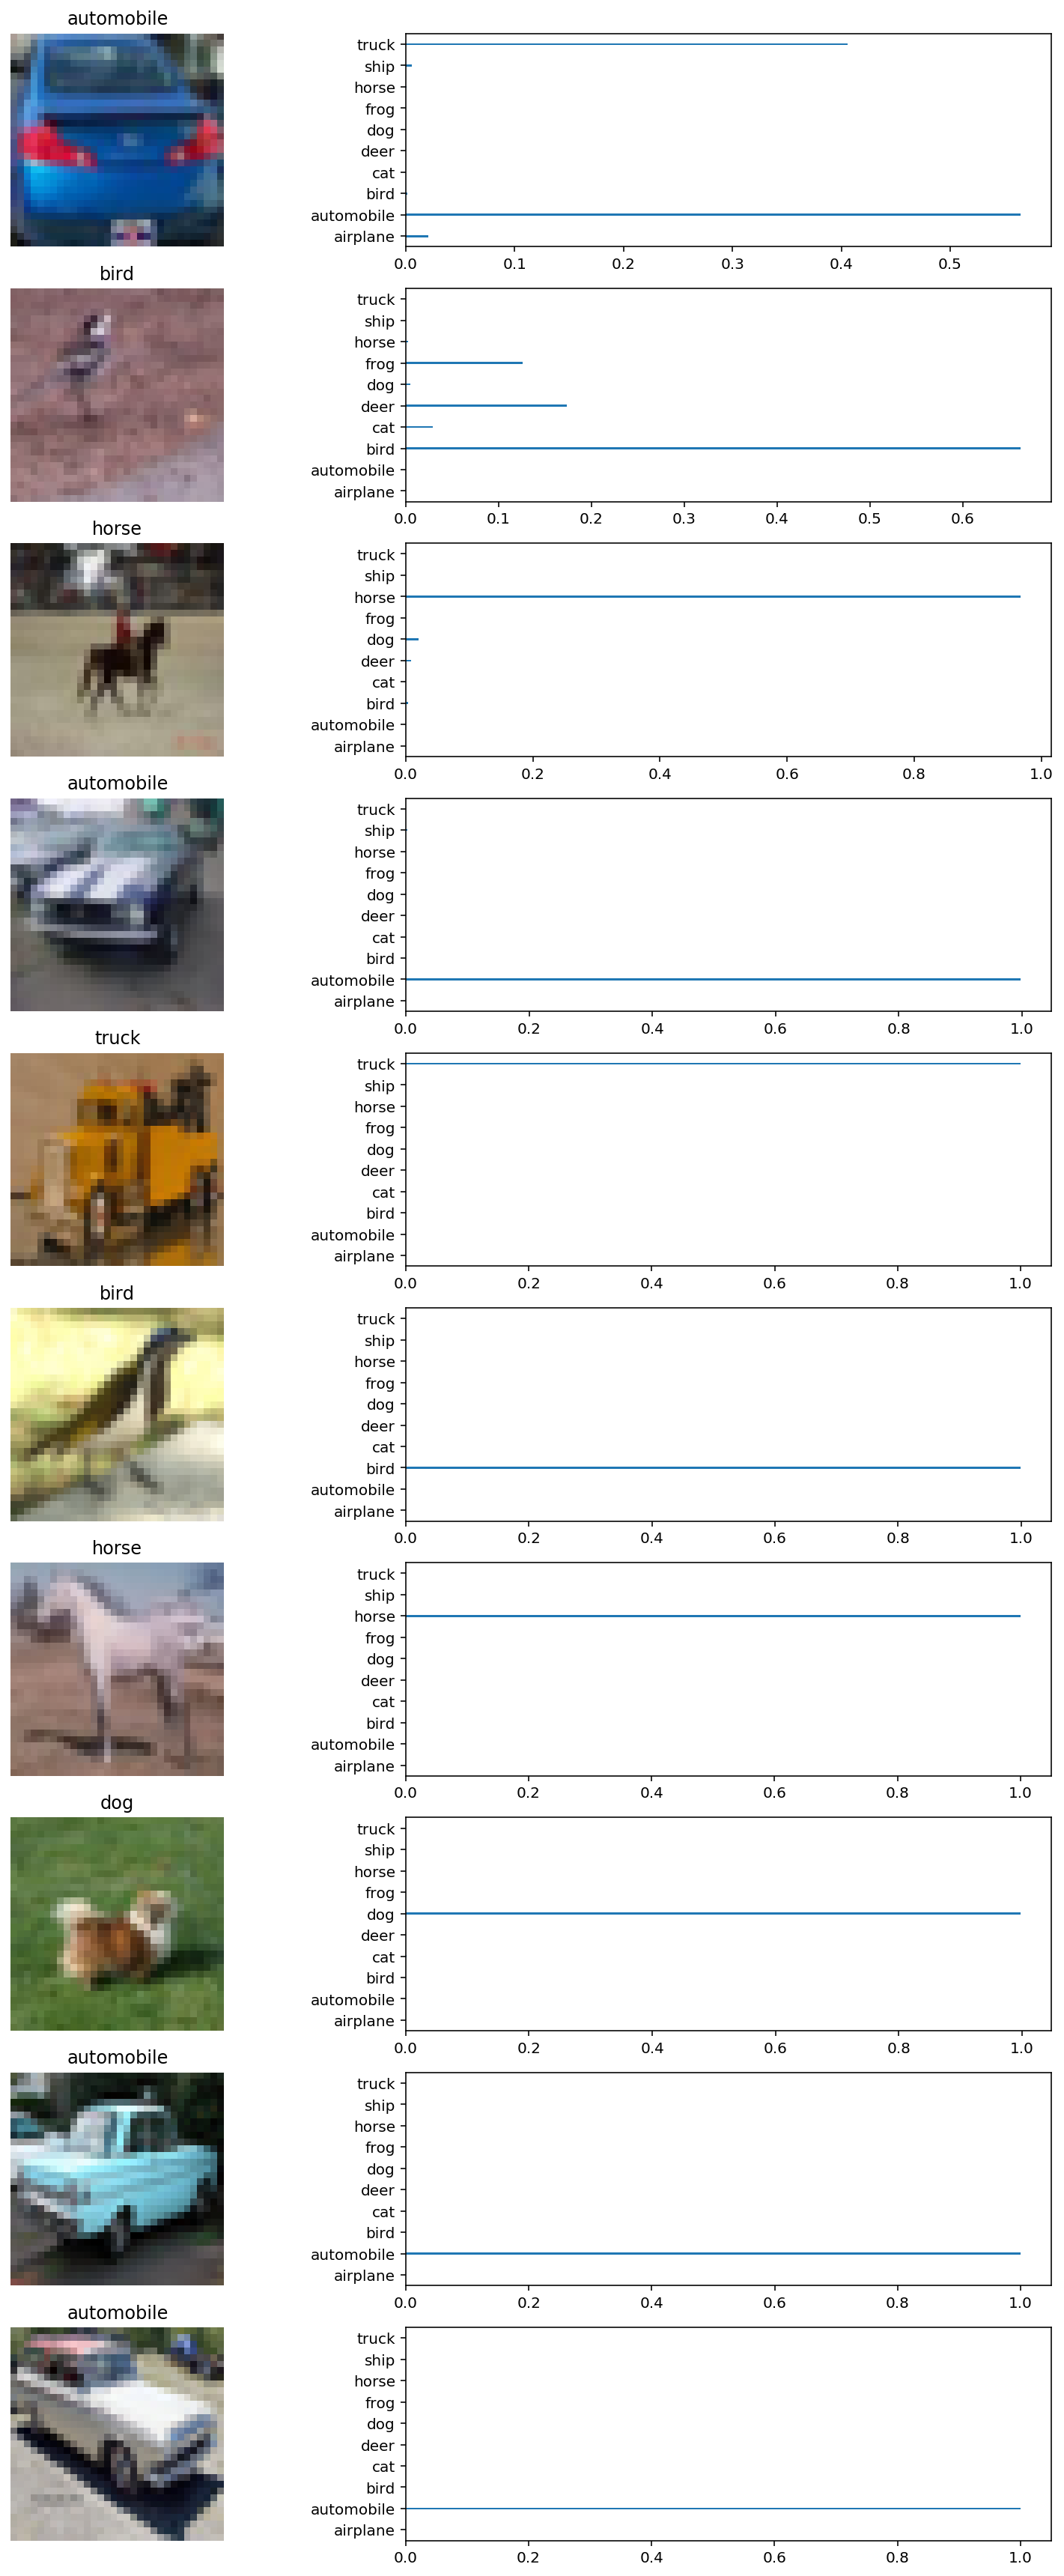

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import tensorflow as tf

save_model_path = '/content/gdrive/My Drive/CIFAR10_checkpoints/image_classification_10'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model(tmpFeatures):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input:0')
        loaded_y = loaded_graph.get_tensor_by_name('label:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in network.dataset.batch_features_labels(tmpFeatures, test_labels):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        tmpTestFeatures = []
    
        for feature in random_test_features:
            tmpFeature = feature
            tmpTestFeatures.append(tmpFeature)
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: tmpTestFeatures, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(tmpFeatures)
